# Lorenz-63 model
In this Notebook we'll demonstrate how to construct multivariate models. To this end, we shall consider a stochastic Lorenz-63 model, defined as 

\begin{equation}
    \begin{cases}
        \mathrm{d}X_t = -S (X_t - Y_t) \mathrm{d}t + \mathrm{d}W^x_t, \\
        \mathrm{d}Y_t = (RX_t - Y_t - X_tY_t) \mathrm{d}t + \mathrm{d}W^y_t, \\
        \mathrm{d}Z_t = (X_tY_t - BZ_t) \mathrm{d}t + \mathrm{d}W^z_t,
    \end{cases}
\end{equation}

where $\{W^i_t\}$ are 1-dimensional Wiener processes and $(S, R, B) \in \mathbb{R}^3$. We assume that we collect discrete observations of the above system via the following set of equations

\begin{equation}
    \begin{cases}
        U^1_t = k_o X_t + V^1_t, \\
        U^2_t = k_o Z_t + V^2_t,
    \end{cases}
\end{equation}

where $k_o > 0$, and $V^i_t \sim \mathcal{N}(0, \sigma)$ where $\sigma^2 = 0.1$.

Next, we define the inital distributions as

\begin{equation}
    X_0 \sim \mathcal{N}(-5.9162, \sqrt{10}), \quad Y_0 \sim \mathcal{N}(-5.52332, \sqrt{10}), \quad Z_0 \sim \mathcal{N}(24.5723, \sqrt{10}),
\end{equation}

which means that the model equations are given by

In [1]:
import torch
import math
from pyro.distributions import Normal
from torch.distributions import Distribution


Distribution.set_default_validate_args(False)


def f(x, s, r, b, sigma):
    x_t = -s * (x.value[..., 0] - x.value[..., 1])
    y_t = r * x.value[..., 0] - x.value[..., 1] - x.value[..., 0] * x.value[..., 2]
    z_t = x.value[..., 0] * x.value[..., 1] - b * x.value[..., 2]

    return torch.stack((x_t, y_t, z_t), dim=-1), sigma


For this example we'll simulate data, we do this by setting $(S, R, B) \triangleq (10, 28, 8/3)$, and solve the SDE using $\Delta t = 0.01$. Furthermore, we assume that we get observations every 0.1 time units, which amounts to observing every 10th data point

In [2]:
import matplotlib.pyplot as plt
from stochproc import timeseries as ts, distributions as dists
from pyfilter import inference


def initial_kernel(x0, s0):
    return Normal(loc=x0, scale=s0).to_event(1)


def build_model(s, r, b, observe_every_step=1, device="cpu:0"):
    mean = torch.tensor([-5.91652, -5.52332, 24.5723]).to(device)
    scale = math.sqrt(10) * torch.ones(3).to(device)

    dt = 1e-2
    sigma = torch.tensor(1.0, device=device)
    
    increment_dist = Normal(loc=0.0, scale=math.sqrt(dt)).to(device).expand(mean.shape).to_event(1)
    hidden = ts.AffineEulerMaruyama(f, (s, r, b, sigma), increment_dist, initial_kernel=initial_kernel, dt=dt, initial_parameters=(mean, scale))

    mat = torch.tensor([
        [0.8, 0.0, 0.0],
        [0.0, 0.0, 0.8]
    ]).to(device)

    scale = torch.tensor(0.1).sqrt().unsqueeze(-1).to(device)

    return ts.LinearStateSpaceModel(hidden, (mat, scale), torch.Size([2]), observe_every_step=observe_every_step)

sim_model = build_model(10.0, 28.0, 8.0 / 3.0, 10)
path = sim_model.sample_states(10_000)
x, y = path.get_paths()

/home/tingis/anaconda3/lib/python3.9/site-packages/stochproc/timeseries/linear.py:40: UserWarning: You only passed two parameters, inferring that the offset parameter should be 0! Suppress this warning by passing three parameters
  warn(


And plot each component individually (i.e. no butterfly pattern)

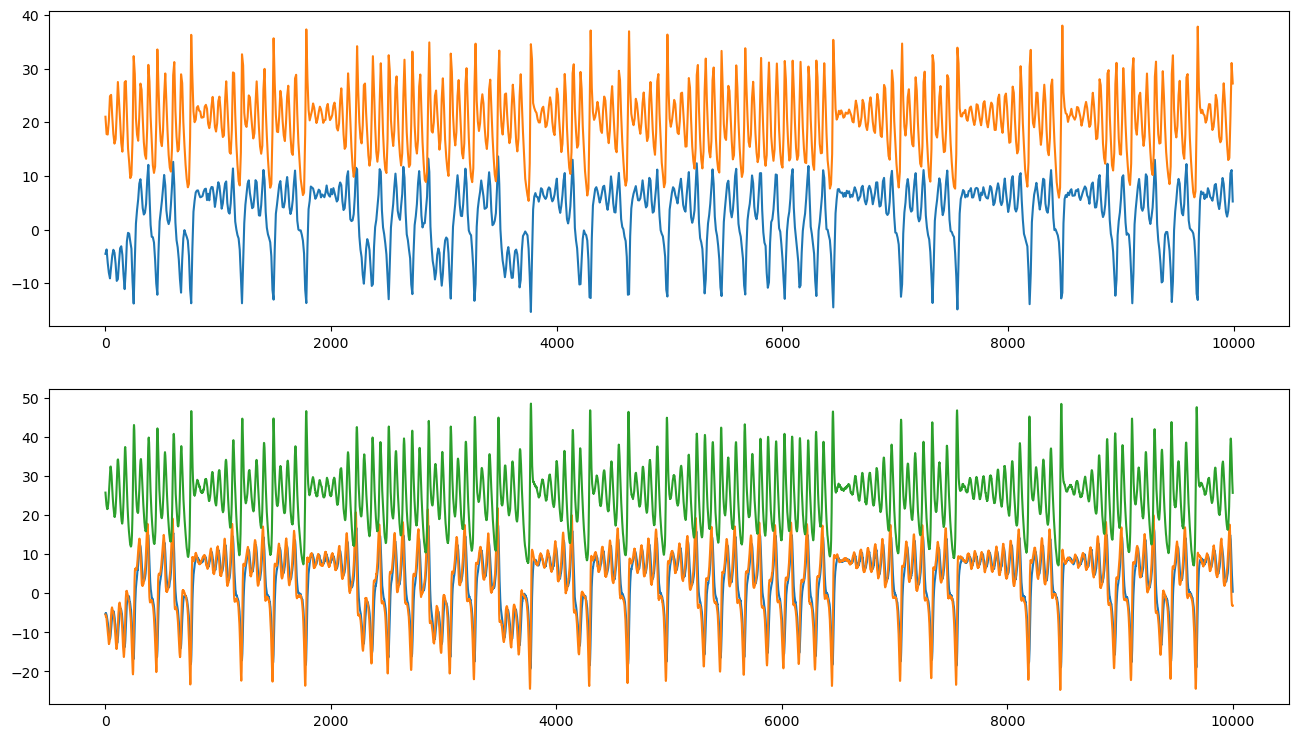

In [3]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (16, 9)

fig, ax = plt.subplots(2)

mask = ~torch.isnan(y).all(dim=1)

ax[1].plot(path.time_indexes, x)
ax[0].plot(path.time_indexes[mask], y[mask])

Where the upper plot is the observble data, and the lower is the hidden processes. Next, we shall perform the inference, for which we use NESS to target the parameters, and the APF together with the optimal proposal kernel for the states

In [4]:
from pyfilter import inference as inf, filters as filts
from pyro.distributions import Uniform


def build_prob_model(context):
    s = context.named_parameter("s", Uniform(low=5.0, high=40.0).cuda())
    r = context.named_parameter("r", Uniform(low=10.0, high=50.0).cuda())
    b = context.named_parameter("b", Uniform(low=1.0, high=20.0).cuda())
        
    return build_model(s, r, b, device="cuda:0")


train = y.cuda()

result = list()
for i in range(2):
    with inf.make_context() as context:            
        filt_ = filts.particle.APF(build_prob_model, 400, proposal=filts.particle.proposals.LinearGaussianObservations())
        alg = inf.sequential.NESS(filt_, 1_000)
    
        state = alg.fit(train)
        result.append((state, context))

NESS: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 314.54it/s]


Let's plot the filter means together with the hidden states for last 100 observations.

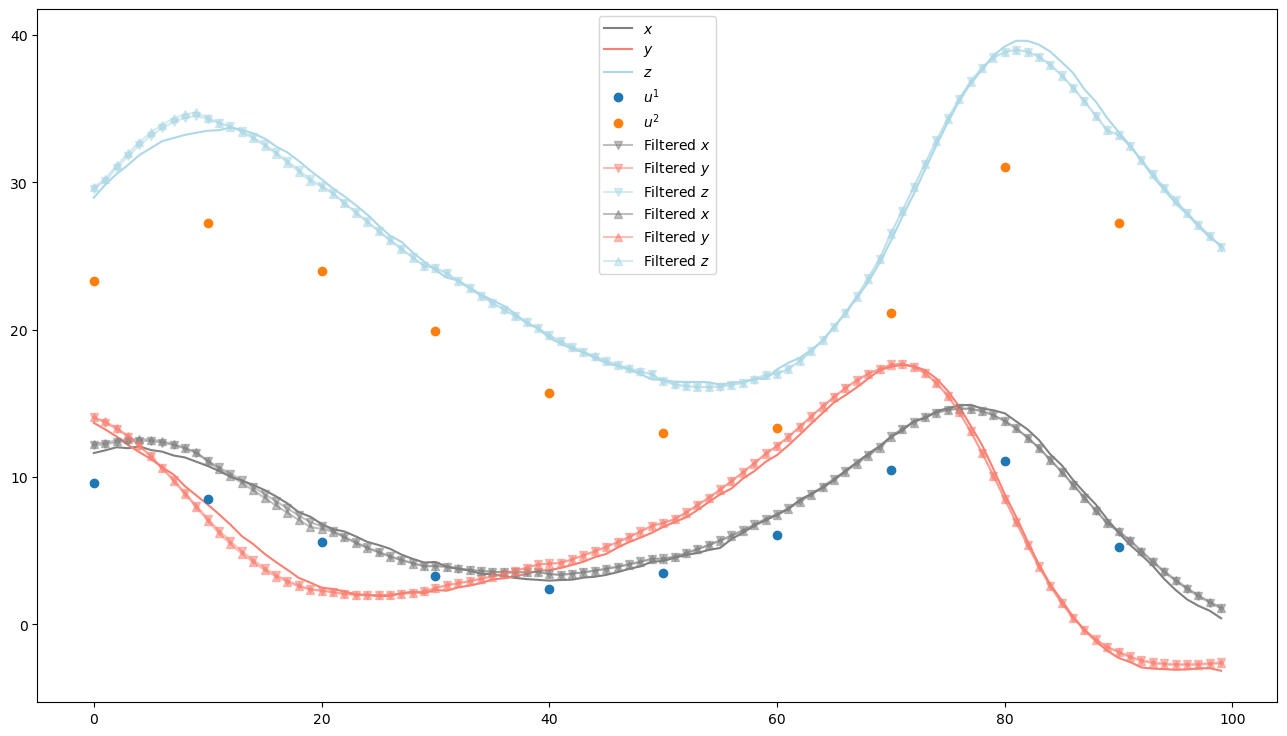

In [5]:
import pandas as pd

fig, ax = plt.subplots()

states = ['$x$', '$y$', '$z$']
colors = ["gray", "salmon", "lightblue"]
markers = ["v", "^"]

last_obs = 100

pd.DataFrame(x[-last_obs:].numpy(), columns=states).plot(ax=ax, color=colors)
pd.DataFrame(y[-last_obs:].numpy(), columns=["$u^1$", "$u^2$"]).plot(ax=ax, marker="o", linestyle="None")

for j, (state, _) in enumerate(result):
    mean = state.filter_state.filter_means[-last_obs:].mean(dim=1).cpu().numpy()    
    pd.DataFrame(mean, columns=[f'Filtered {s}' for s in states]).plot(ax=ax, alpha=0.5, color=colors, marker=markers[j])

And finally plot the posterior distributions

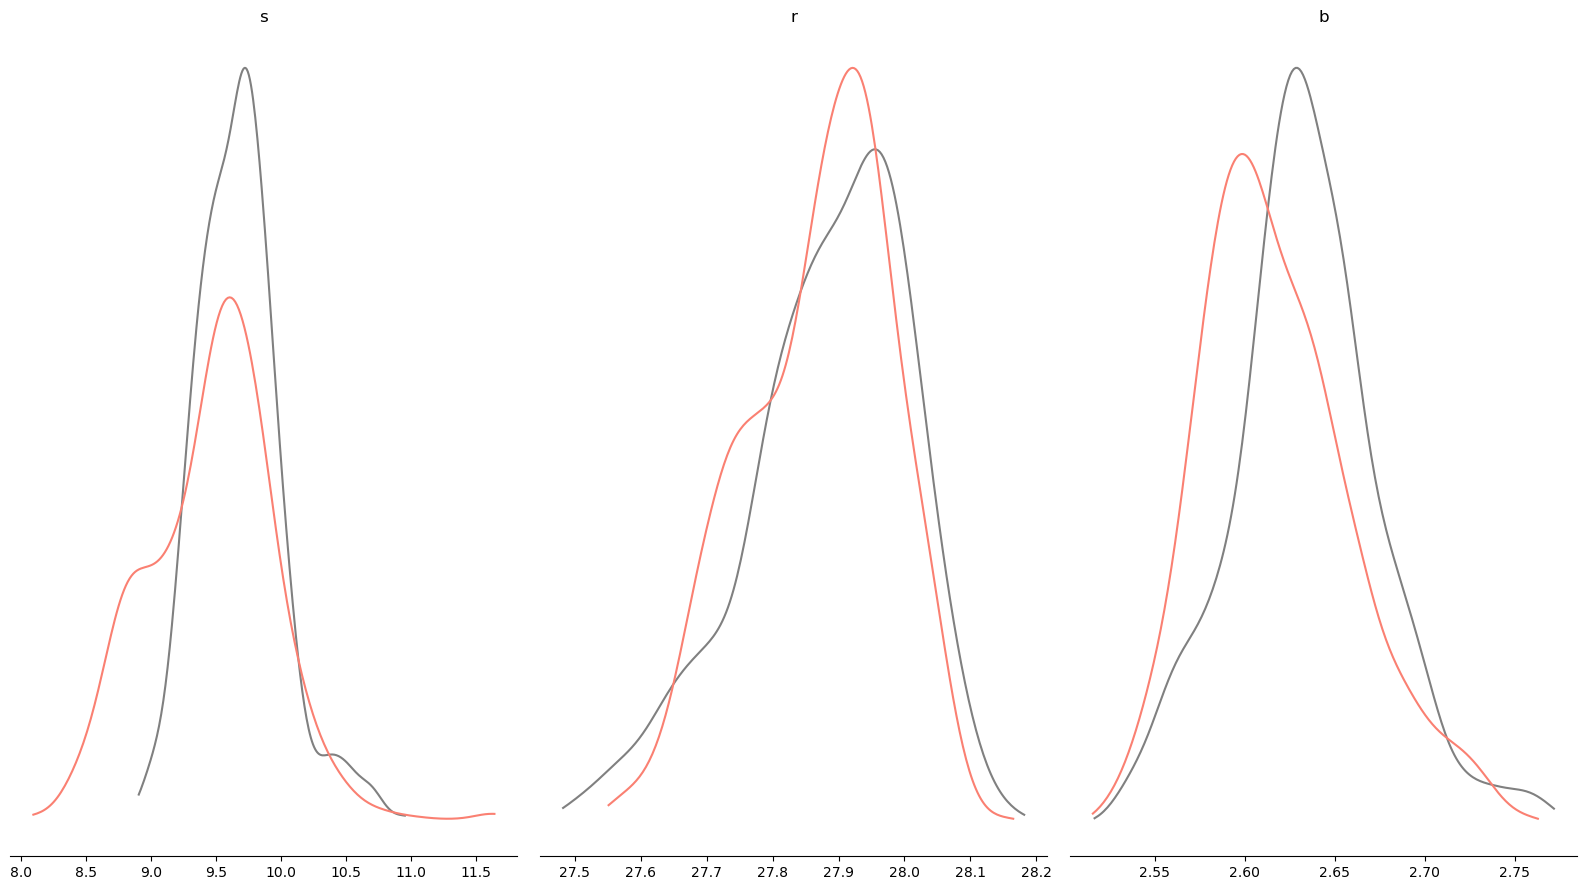

In [6]:
from pyfilter.inference import plot

ax = None
for j, (state, context) in enumerate(result):
    ax = plot.mimic_arviz_posterior(context, state, ax=ax, color=colors[j])

plt.tight_layout()